# Mask Creation and Image Processing - Dennis Loevlie

## Front of Mask 

In [1]:
import matplotlib
from PIL import Image
import numpy as np 
matplotlib.use('TkAgg')
from matplotlib.widgets import Cursor
import matplotlib.pyplot as plt 
import os 
pil = Image.open("./AuPdAuPbWrr0728Over/AuPdAuPbWrr0728A_y20m07d28H13M01S53.jpg")
im = np.array(pil)
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')
cursor = Cursor(ax, useblit=True, color='red', linewidth=2)

ax.imshow(im)

pts = plt.ginput(4) # number of clicks

### **Now to define the individual points**

Sorting the points selected by the user

In [2]:
from operator import itemgetter
sorted_list = sorted(pts,key=itemgetter(1,0))
bottom_left_pt = sorted_list[0]
bottom_right_pt = sorted_list[1]
top_left_pt = sorted_list[2]
top_right_pt = sorted_list[3]

Manually choose the number of Rows and Columns

In [3]:
Row_Number = 9  
Col_Number = 12

Getting the centers

In [4]:
# Locating the centers of every well assuming linear spacing

centers = []
index = []

left_side_x = np.linspace(bottom_left_pt[0],top_left_pt[0],Row_Number)
left_side_y = np.linspace(bottom_left_pt[1],top_left_pt[1],Row_Number)

right_side_x = np.linspace(bottom_right_pt[0],top_right_pt[0],Row_Number)
right_side_y = np.linspace(bottom_right_pt[1],top_right_pt[1],Row_Number)
count = 0

for i in range(len(left_side_x)):
    X_points = np.linspace(left_side_x[i],right_side_x[i],Col_Number)
    Y_points = np.linspace(left_side_y[i],right_side_y[i],Col_Number)
    for j, x in enumerate(X_points):
        centers.append([x,Y_points[j]])
        count += 1
        index.append(count)

X_points = [pt[0] for pt in centers]
Y_points = [pt[1] for pt in centers]

### The cell below will allow the user to drag and fix the well locations 

In [5]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
image5 = im.copy() # Copying the original image of the plate
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')
ax.imshow(image5)

class DraggablePoints(object):
    def __init__(self, artists, tolerance=5):
        for artist in artists:
            artist.set_picker(tolerance)
        self.artists = artists
        self.currently_dragging = False
        self.current_artist = None
        self.offset = (0, 0)

        for canvas in set(artist.figure.canvas for artist in self.artists):
            canvas.mpl_connect('button_press_event', self.on_press)
            canvas.mpl_connect('button_release_event', self.on_release)
            canvas.mpl_connect('pick_event', self.on_pick)
            canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        self.currently_dragging = True

    def on_release(self, event):
        self.currently_dragging = False
        self.current_artist = None

    def on_pick(self, event):
        if self.current_artist is None:
            self.current_artist = event.artist
            x0, y0 = event.artist.center
            x1, y1 = event.mouseevent.xdata, event.mouseevent.ydata
            self.offset = (x0 - x1), (y0 - y1)

    def on_motion(self, event):
        if not self.currently_dragging:
            return
        if self.current_artist is None:
            return
        dx, dy = self.offset
        self.current_artist.center = event.xdata + dx, event.ydata + dy
        self.current_artist.figure.canvas.draw()

if __name__ == '__main__':
    circles = []
    for center in centers:
        circles.append(patches.Circle(tuple(center),56-6, fc='r', alpha=0.2))
    
    for circ in circles:
        ax.add_patch(circ)

    dr = DraggablePoints(circles)
    plt.show()

Collecting the new center values

In [6]:
for i in range(len(centers)):
    centers[i] = circles[i].center

In [7]:
import pandas as pd 
Centers = {f'Well {i}':centers[i] for i in range(len(centers))}
df_centers_front = pd.DataFrame(Centers)
df_centers_front['Well 0']
df_centers_front.to_csv('Centers_front.csv')

### Creating the mask

In [8]:
#%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import skimage
from skimage.viewer import ImageViewer
from skimage import color

image2 = im.copy() # Copying the original image of the plate
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')

mask = np.ones(shape=image2.shape[0:2], dtype="bool") # create the mask image
R = 56 - 15 # Radius of circles
i = 1

for coor in centers:
    x = int(coor[0])
    y = int(coor[1])
    rr, cc = skimage.draw.circle(y, x, radius=R, shape=image2.shape[0:2])
    i = 2
    mask[rr, cc] = False

# Apply the mask
image2[mask] = 0
ax.imshow(image2)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Viewer requires Qt
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


In [9]:
im3 = Image.fromarray(image2)
im3.save("Plate_Image.jpg")

In [10]:
image2_BW = im.copy()
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')

mask = np.ones(shape=image2.shape[0:2], dtype="bool") # create the mask image
R = 56 - 15 # Radius of circles
i = 1

for coor in centers:
    x = int(coor[0])
    y = int(coor[1])
    rr, cc = skimage.draw.circle(y, x, radius=R, shape=image2.shape[0:2])
    i = 2
    mask[rr, cc] = False

# Apply the mask
image2_BW[mask] = 0
image2_BW[image2_BW>0]=1
image_test = im.copy()
ax.imshow(image_test*image2_BW)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  if sys.path[0] == '':


**Saving the Mask Image**

In [11]:
im4 = Image.fromarray(image2_BW)
im4.save("Plate_Image_Mask.jpg")

## Making second mask for under (same process as for the first mask)

In [15]:
import matplotlib
from PIL import Image
import numpy as np 
matplotlib.use('TkAgg')
from matplotlib.widgets import Cursor
import matplotlib.pyplot as plt 
import os 
pil = Image.open("./AuPdAuPbWrr0728Under2/AuPdAuPbWrr0728_y20m07d28H13M01S53.jpg")
im = np.array(pil)
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')
cursor = Cursor(ax, useblit=True, color='red', linewidth=2)

ax.imshow(im)

pts = plt.ginput(4) # number of clicks

In [16]:
from operator import itemgetter
sorted_list = sorted(pts,key=itemgetter(1,0))
bottom_left_pt = sorted_list[0]
bottom_right_pt = sorted_list[1]
top_left_pt = sorted_list[3]
top_right_pt = sorted_list[2]

In [17]:
Row_Number = 9  
Col_Number = 12

In [18]:
# Locating the centers of every well assuming linear spacing

centers = []
index = []

left_side_x = np.linspace(bottom_left_pt[0],top_left_pt[0],Row_Number)
left_side_y = np.linspace(bottom_left_pt[1],top_left_pt[1],Row_Number)

right_side_x = np.linspace(bottom_right_pt[0],top_right_pt[0],Row_Number)
right_side_y = np.linspace(bottom_right_pt[1],top_right_pt[1],Row_Number)
count = 0

for i in range(len(left_side_x)):
    X_points = np.linspace(left_side_x[i],right_side_x[i],Col_Number)
    Y_points = np.linspace(left_side_y[i],right_side_y[i],Col_Number)
    for j, x in enumerate(X_points):
        centers.append([x,Y_points[j]])
        count += 1
        index.append(count)

X_points = [pt[0] for pt in centers]
Y_points = [pt[1] for pt in centers]

In [19]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
image5 = im.copy() # Copying the original image of the plate
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')
ax.imshow(image5)

class DraggablePoints(object):
    def __init__(self, artists, tolerance=5):
        for artist in artists:
            artist.set_picker(tolerance)
        self.artists = artists
        self.currently_dragging = False
        self.current_artist = None
        self.offset = (0, 0)

        for canvas in set(artist.figure.canvas for artist in self.artists):
            canvas.mpl_connect('button_press_event', self.on_press)
            canvas.mpl_connect('button_release_event', self.on_release)
            canvas.mpl_connect('pick_event', self.on_pick)
            canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        self.currently_dragging = True

    def on_release(self, event):
        self.currently_dragging = False
        self.current_artist = None

    def on_pick(self, event):
        if self.current_artist is None:
            self.current_artist = event.artist
            x0, y0 = event.artist.center
            x1, y1 = event.mouseevent.xdata, event.mouseevent.ydata
            self.offset = (x0 - x1), (y0 - y1)

    def on_motion(self, event):
        if not self.currently_dragging:
            return
        if self.current_artist is None:
            return
        dx, dy = self.offset
        self.current_artist.center = event.xdata + dx, event.ydata + dy
        self.current_artist.figure.canvas.draw()

if __name__ == '__main__':
    circles = []
    for center in centers:
        circles.append(patches.Circle(tuple(center),56, fc='r', alpha=0.2))
    
    for circ in circles:
        ax.add_patch(circ)

    dr = DraggablePoints(circles)
    plt.show()

In [20]:
for i in range(len(centers)):
    centers[i] = circles[i].center

In [21]:
import pandas as pd 
Centers = {f'Well {i}':centers[i] for i in range(len(centers))}
df_centers_front = pd.DataFrame(Centers)
df_centers_front['Well 0']
df_centers_front.to_csv('Centers_back.csv')

In [13]:
import pandas as pd
centers_back = pd.read_csv('Centers_back.csv')
CB = centers_back.drop('Unnamed: 0',axis=1)
CB_array = CB.to_numpy()
centers_back = [(CB_array[0][i],CB_array[1][i]) for i in range(len(CB_array[0]))]
centers = centers_back

In [15]:
pil = Image.open("./AuPdAuPbWrr0728Under2/AuPdAuPbWrr0728_y20m07d28H13M01S53.jpg")
im = np.array(pil)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


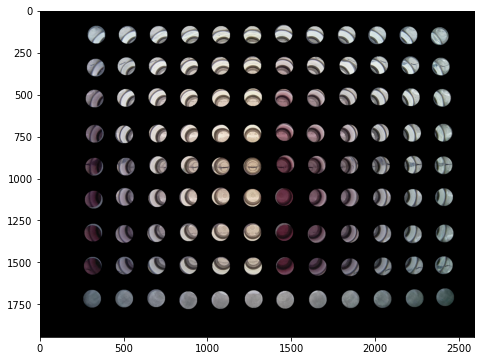

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import skimage
from skimage.viewer import ImageViewer
from skimage import color

image2 = im.copy() # Copying the original image of the plate
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')

mask = np.ones(shape=image2.shape[0:2], dtype="bool") # create the mask image
R = 56 - 3 # Radius of circles
i = 1

for coor in centers:
    x = int(coor[0])
    y = int(coor[1])
    rr, cc = skimage.draw.circle(y, x, radius=R, shape=image2.shape[0:2])
    i = 2
    mask[rr, cc] = False

# Apply the mask
image2[mask] = 0
ax.imshow(image2)

In [17]:
im7 = Image.fromarray(image2)
im7.save("Plate_Back_Image.jpg")

In [20]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  if sys.path[0] == '':


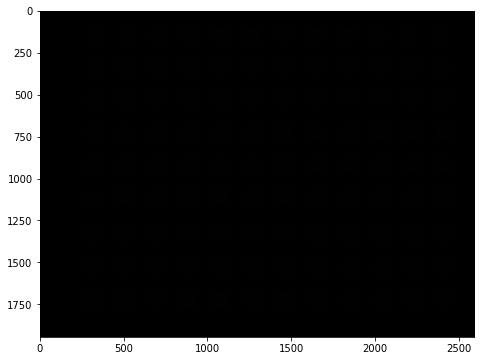

In [21]:
image2_BW = im.copy()
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')

mask = np.ones(shape=image2.shape[0:2], dtype="bool") # create the mask image
R = 56 - 3 # Radius of circles
i = 1

for coor in centers:
    x = int(coor[0])
    y = int(coor[1])
    rr, cc = skimage.draw.circle(y, x, radius=R, shape=image2.shape[0:2])
    i = 2
    mask[rr, cc] = False

# Apply the mask
image2_BW[mask] = 0
image2_BW[image2_BW!=0]=1

ax.imshow(image2_BW)

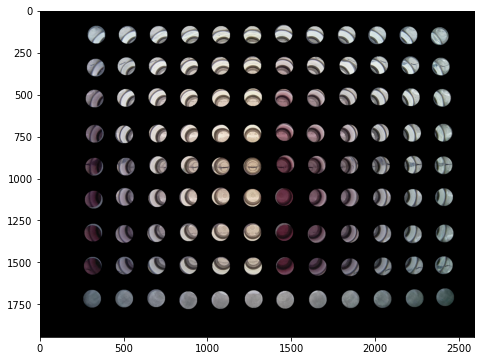

In [31]:
fig =  plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, facecolor='#FFFFCC')
ax.imshow(image2_BW)

In [19]:
im20 = Image.fromarray(image2_BW)
im20.save("Plate_Back_Image_Mask.jpg")